# Ritz Example - Cantilever Beam

We can consider a cantilever beam with an end-load as a simple example of using the Ritz method to solve problems.

![end-loaded cantilever beam](cantilever.jpg "Cantilever Beam")

## Initial setup

In this exmample, we are trying to approximate the vertical displacement, $w$ as a function of the horizontal distance, $x$.

We will consider both polynomial and trigonometric forms for $w(x)$.

For a simpel Euler-Bernoulli beam, stress is only a function of $w(x)$ and all stress terms other than $\sigma_{xx}$ are zero.
This gives the strain energy density as
$$
U = \frac{\sigma_{11}^2}{2E} = \frac{M^2 y^2}{2EI^2} = \frac{E}{2}\left(\frac{d^2 w}{dx^2}\right)^2 y^2
$$

We integrate over the volume to find the total strain energy in the beam
$$
		U_T = \int_0^L \left[\iint_A \frac{E}{2}\left(\frac{d^2 w}{dx^2}\right)^2 y^2 dA \right] dx
$$
$$
        = \int_0^L \frac{EI}{2}\left(\frac{d^2 w}{dx^2}\right)^2 dx
$$

The work done by external forces is quite simple in this case
$$
		W = Pw(L)
$$

Now we will formulate the problem in code and try a few different trial functions.
In python I first need to load a few libraries (symbolic math, array-math, and plotting)

In [2]:
#first command is for figures in live notebooks
%matplotlib inline
import sympy as sm
import numpy as np
from matplotlib import pyplot as plt
sm.init_printing() #pretty output

The following are Python functions to build a polynomial trial function for $n$ terms

In [16]:
#define some global symbols
x,P,E,I,L = sm.symbols('x P E I L')

def poly_func(n):
    w = 0
    a = []
    for i in range(n+1): #plus 1 to match the polynomial order we expect
        a.append(sm.symbols('a'+str(i)))
        w = w + a[i]*x**i
    return w, a


Now we consider a few polynomial functions

In [4]:
poly2, a2 = poly_func(2)
poly3, a3 = poly_func(3)
poly4, a4 = poly_func(4)
poly4

Next we need to ensure that these functions satisfy the boundary conditions, namely that $w(0) = 0$ and $w'(0)=0$

In [23]:
#general function for cantilver BC's at x=0
def bcs(func,a):
    ans = sm.solve([func.subs(x,0),sm.diff(func,x).subs(x,0)],[a[0],a[1]])
    return func.subs(ans), a[2:]

poly2, a2 = bcs(poly2, a2)
poly3, a3 = bcs(poly3, a3)
poly4, a4 = bcs(poly4, a4)


IndexError: list index out of range

Now we repeat for a few trigonometric functions, note that our trigonometric function automatically satisfiws $w(0) = 0$, so we need to modify our bc's function slightly, and for convenience we will build that function into the trig_func generator.

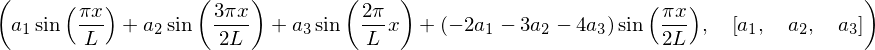

In [6]:
def trig_func(n):
    w = 0
    a = []
    #generate trig function
    for i in range(n):
        a.append(sm.symbols('a'+str(i)))
        w = w + a[i]*sm.sin((i+1)*sm.pi*x/(2*L))
    #enforce bc's
    ans = sm.solve([sm.diff(w,x).subs(x,0)],[a[0]])
    return w.subs(ans), a[1:]
trig2, at2 = trig_func(2)
trig3, at3 = trig_func(3)
trig4, at4 = trig_func(4)
trig4, at4

Now we find the total potential energy
$$
\Pi = U_t - W = \int_0^L \frac{EI}{2}\left(\frac{d^2 w}{dx^2}\right)^2 dx - Pw(L)
$$

In [7]:
Pi_p2 = sm.integrate(E*I/2*sm.diff(poly2,x,x)**2,(x,0,L))-P*poly2.subs(x,L)
Pi_p3 = sm.integrate(E*I/2*sm.diff(poly3,x,x)**2,(x,0,L))-P*poly3.subs(x,L)
Pi_p4 = sm.integrate(E*I/2*sm.diff(poly4,x,x)**2,(x,0,L))-P*poly4.subs(x,L)
Pi_t2 = sm.integrate(E*I/2*sm.diff(trig2,x,x)**2,(x,0,L))-P*trig2.subs(x,L)
Pi_t3 = sm.integrate(E*I/2*sm.diff(trig3,x,x)**2,(x,0,L))-P*trig3.subs(x,L)
Pi_t4 = sm.integrate(E*I/2*sm.diff(trig4,x,x)**2,(x,0,L))-P*trig4.subs(x,L)

And now we solve the system $\frac{\partial \Pi}{\partial a_j} = 0$ for each trial function.
Since the number of coefficients we are solving for will vary, we will write a function to do this

In [8]:
def mysolver(Pi,a):
    eqns = []
    for i in range(len(a)):
        eqns.append(sm.diff(Pi,a[i]))
    return sm.solve(eqns,a)

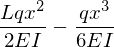

In [22]:
w_p2 = poly2.subs(mysolver(Pi_p2,a2))
w_p3 = poly3.subs(mysolver(Pi_p3,a3))
w_p4 = poly4.subs(mysolver(Pi_p4,a4))
w_t2 = trig2.subs(mysolver(Pi_t2,at2))
w_t3 = trig3.subs(mysolver(Pi_t3,at3))
w_t4 = trig4.subs(mysolver(Pi_t4,at4))
w_p4

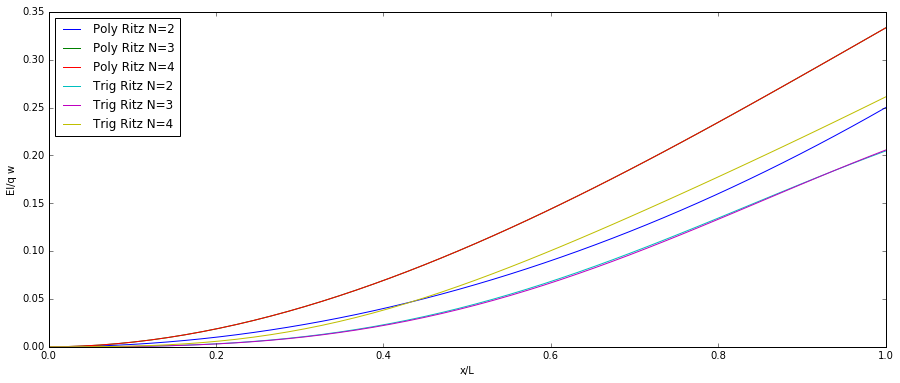

In [10]:
plt.figure(figsize=(15,6),dpi=80)

xs = np.linspace(0,1)
wl_p2 = sm.lambdify(x,w_p2.subs([(P,1),(E,1),(I,1),(L,1)]))
wl_p3 = sm.lambdify(x,w_p3.subs([(P,1),(E,1),(I,1),(L,1)]))
wl_p4 = sm.lambdify(x,w_p4.subs([(P,1),(E,1),(I,1),(L,1)]))
wl_t2 = sm.lambdify(x,w_t2.subs([(P,1),(E,1),(I,1),(L,1)]))
wl_t3 = sm.lambdify(x,w_t3.subs([(P,1),(E,1),(I,1),(L,1)]))
wl_t4 = sm.lambdify(x,w_t4.subs([(P,1),(E,1),(I,1),(L,1)]))
plt.plot(xs,[wl_p2(k) for k in xs],label='Poly Ritz N=2')
plt.plot(xs,[wl_p3(k) for k in xs],label='Poly Ritz N=3')
plt.plot(xs,[wl_p4(k) for k in xs],label='Poly Ritz N=4')
plt.plot(xs,[wl_t2(k) for k in xs],label='Trig Ritz N=2')
plt.plot(xs,[wl_t3(k) for k in xs],label='Trig Ritz N=3')
plt.plot(xs,[wl_t4(k) for k in xs],label='Trig Ritz N=4')
#plt.plot(xs,xs/24*(1+ xs**3-2*xs**2),'k--',label='exact')
plt.legend(loc='best')
plt.xlabel('x/L')
plt.ylabel('EI/P w')

Note that with N=3 we have recovered the exact solution, and N=4 is redundant, giving the same result as N=3

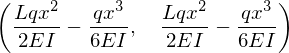

In [12]:
w_p3, w_p4

The trig functions at N=2 and N=3 look very similar, but if we compare the actual solutions they are different

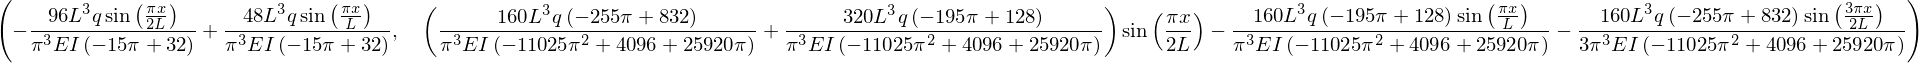

In [14]:
w_t2, w_t3

However in this problem (as we might have expected), trigonometric functions do not perform well, with 4 terms giving only slightly better results than a 2-term polynomial solution.
This is somewhat expected, as trigonometric functions are better-suited to problems with periodicity (like a fixed-fixed beam, for example), but they were included in this example to show that any suitable function form can be used with the Ritz Method.

In [17]:
trig6, at6 = trig_func(6)
Pi_t6 = sm.integrate(E*I/2*sm.diff(trig6,x,x)**2,(x,0,L))-P*trig6.subs(x,L)
w_t6 = trig6.subs(mysolver(Pi_t6,at6))
wl_t6 = sm.lambdify(x,w_t6.subs([(P,1),(E,1),(I,1),(L,1)]))

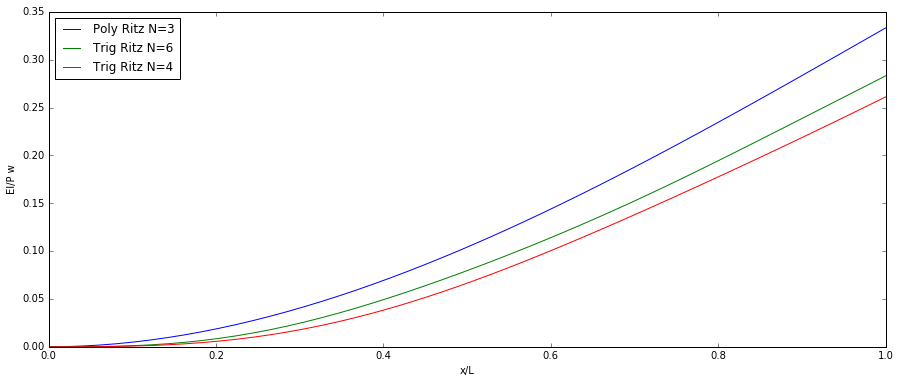

In [21]:
plt.figure(figsize=(15,6),dpi=80)
plt.plot(xs,[wl_p3(k) for k in xs],label='Poly Ritz N=3')
plt.plot(xs,[wl_t6(k) for k in xs],label='Trig Ritz N=6')
plt.plot(xs,[wl_t4(k) for k in xs],label='Trig Ritz N=4')
plt.legend(loc='best')
plt.xlabel('x/L')
plt.ylabel('EI/P w')

In [25]:
poly8, a8 = poly_func(8)
poly8, a8 = bcs(poly8,a8)
poly8

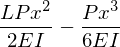

In [27]:
Pi_p8 = sm.integrate(E*I/2*sm.diff(poly8,x,x)**2,(x,0,L))-P*poly8.subs(x,L)
w_p8 = poly8.subs(mysolver(Pi_p8,a8))
w_p8